In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [31]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import *
import scipy.io
import numpy as np
import os
import cv2 as cv
import shutil
import random
import time

In [3]:
img_width, img_height = 224, 224

In [4]:
os.path.exists('data/cars_train')

True

In [5]:
data = ImageDataBunch.from_folder('data/','train','valid',ds_tfms=get_transforms(do_flip=False, flip_vert=True, max_rotate=5.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75),size=224,bs=32).normalize(imagenet_stats)

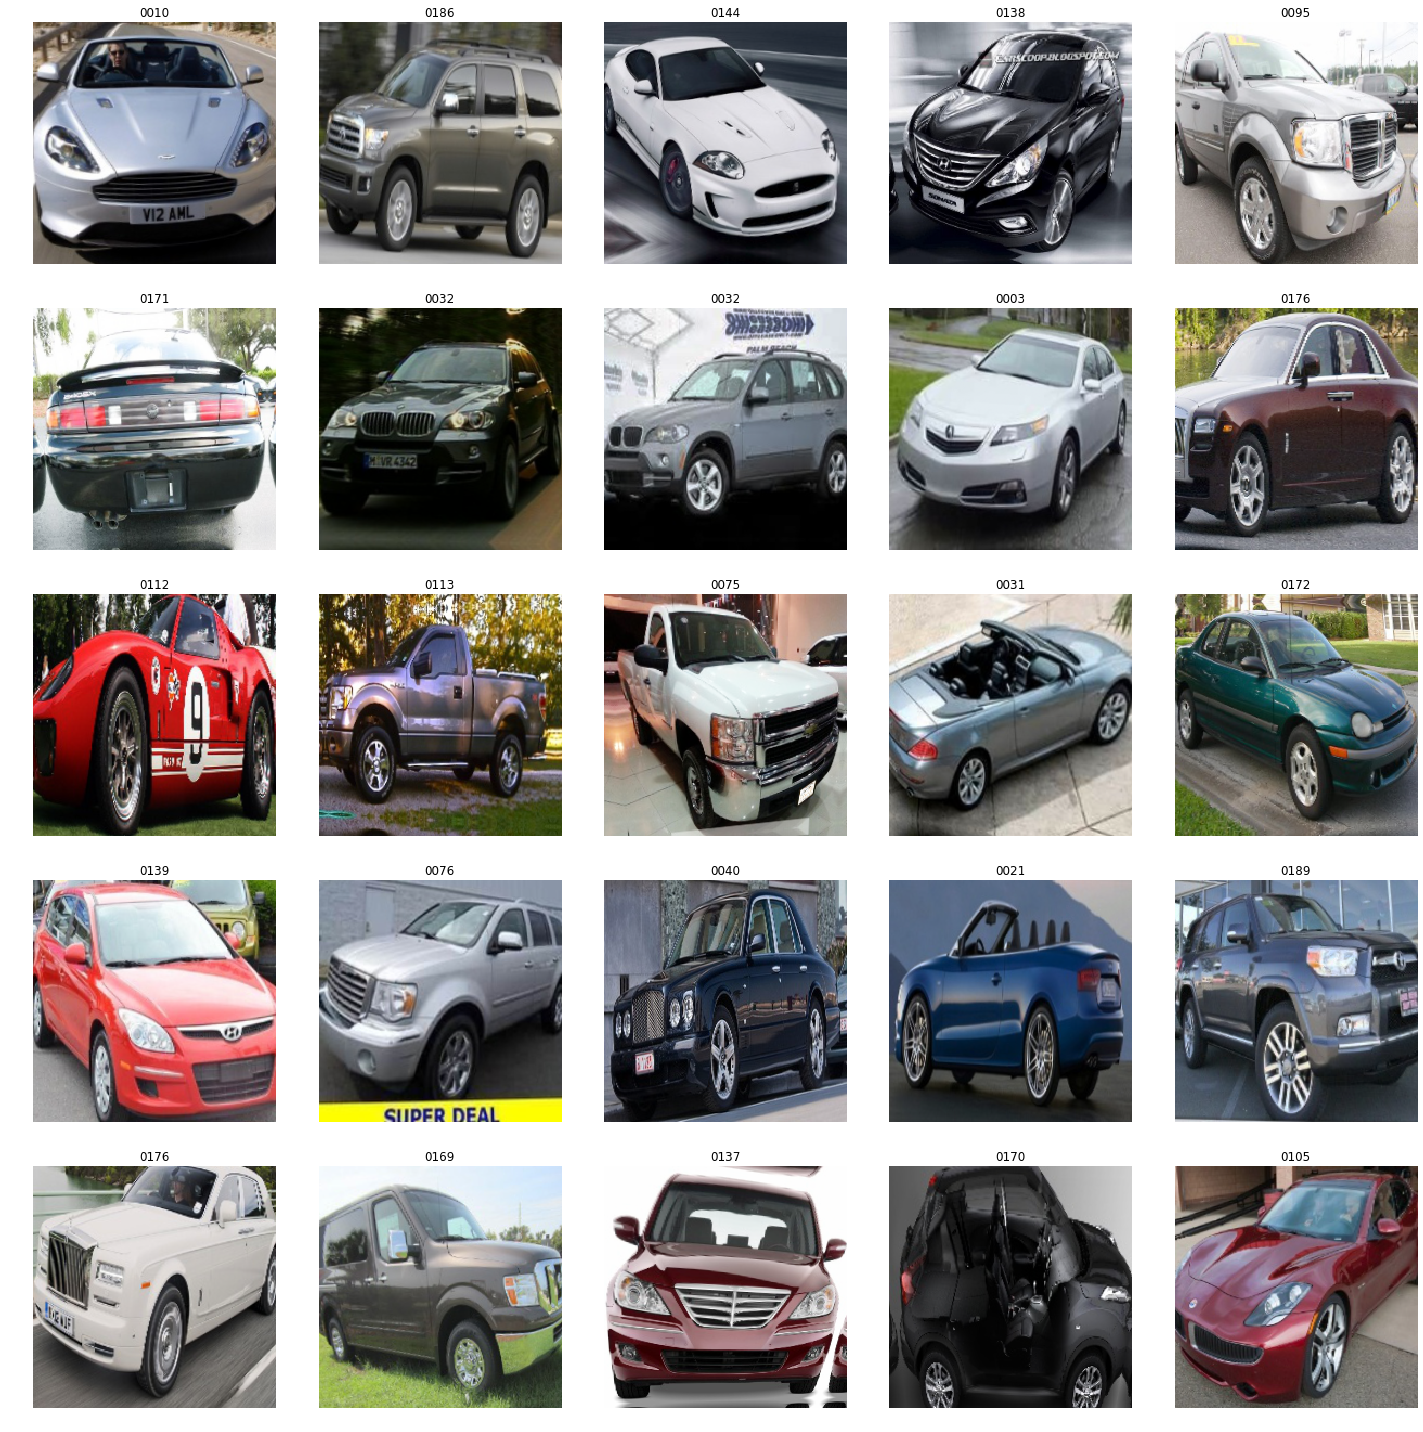

In [6]:
data.show_batch()

In [7]:
# class names and number of classes
print(data.classes)
len(data.classes), data.c

['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038', '0039', '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0057', '0058', '0059', '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069', '0070', '0071', '0072', '0073', '0074', '0075', '0076', '0077', '0078', '0079', '0080', '0081', '0082', '0083', '0084', '0085', '0086', '0087', '0088', '0089', '0090', '0091', '0092', '0093', '0094', '0095', '0096', '0097', '0098', '0099', '0100', '0101', '0102', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '0110', '0111', '0112', '0113', '0114', '0115', '0116', '0117', '0118', '0119', '0120', '0121', '0122', '0123', '0124', '0125',

(196, 196)

In [8]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy).mixup()

In [9]:
learn.fit_one_cycle(16)

epoch,train_loss,valid_loss,accuracy,time
0,5.254577,4.402998,0.107428,02:31
1,4.414005,3.247540,0.276857,02:27
2,3.665478,2.366751,0.440761,02:27
3,3.068540,1.768456,0.548803,02:27
4,2.759219,1.434121,0.629834,02:27
5,2.538567,1.228571,0.669122,02:27
6,2.340120,1.056648,0.724985,02:27
7,2.217688,0.970568,0.751381,02:27
8,2.149644,0.886554,0.773481,02:27
9,1.999705,0.805400,0.798036,02:27


In [10]:
preds,y, loss = learn.get_preds(with_loss=True)
acc = accuracy(preds, y)
print('The accuracy is {0}.'.format(acc))

The accuracy is 0.8330264091491699.


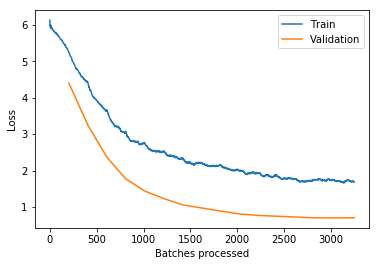

In [11]:
learn.recorder.plot_losses()

In [12]:
learn.save('cv-cars-resnet152-mixup-16e')

In [13]:
# RESULTS
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

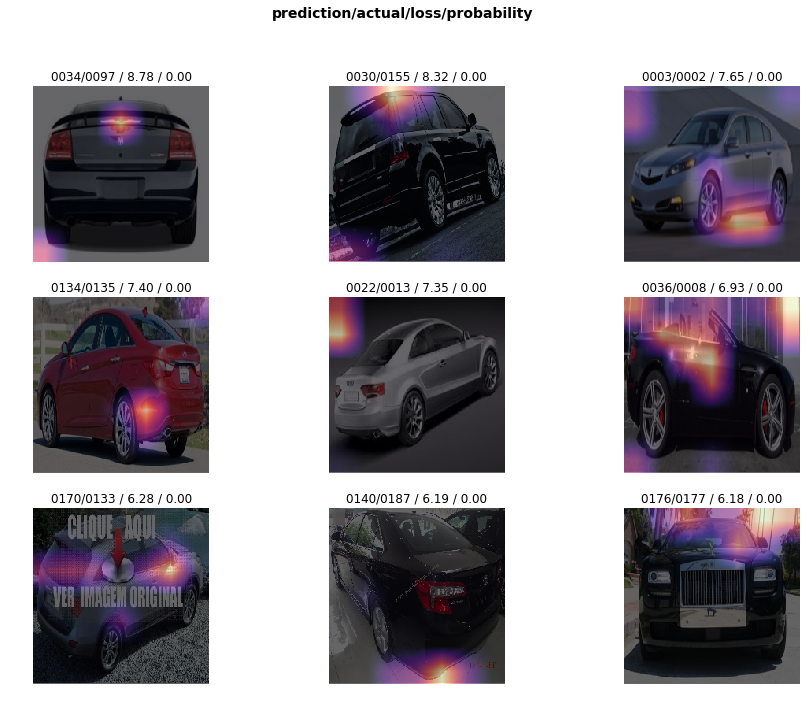

In [14]:
interp.plot_top_losses(9, figsize=(15,11))

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


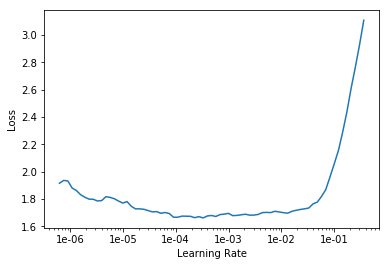

In [16]:
learn.recorder.plot()

In [17]:
learn.unfreeze()
learn.fit_one_cycle(32, max_lr=slice(3e-5,3e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.718557,0.658561,0.841007,03:15
1,1.749338,0.669436,0.839779,03:15
2,1.806171,0.704840,0.831185,03:15
3,1.864318,0.801799,0.799877,03:15
4,1.923644,0.837602,0.783917,03:15
5,1.920204,0.848134,0.783917,03:15
6,2.044269,0.935163,0.745856,03:15
7,1.935215,0.911093,0.772867,03:15
8,1.942047,0.799385,0.797422,03:15
9,1.848135,0.787082,0.804174,03:15


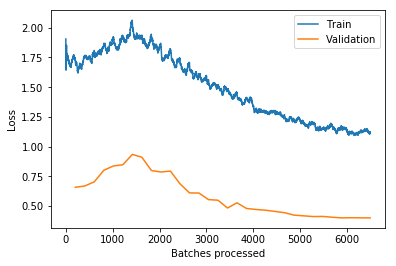

In [18]:
learn.recorder.plot_losses()

In [19]:
learn.save('cv-cars-resnet152-mixup-3e-5-3e-3lr-32e')

In [20]:
learn.export('/home/jupyter/ai-for-sea/data/export-rn152-32e.pkl')

In [21]:
labels = scipy.io.loadmat('//home//jupyter//ai-for-sea//data//cars_test_annos_withlabels.mat')

In [23]:
learn = load_learner('/home/jupyter/ai-for-sea/data/', file='export-rn152-32e.pkl', test= ImageList.from_csv('//home//jupyter//ai-for-sea//data//','test_labels.csv',folder='//test'))
preds,y = learn.TTA(ds_type=DatasetType.Test)

In [24]:
a=preds;a.shape

torch.Size([8041, 196])

In [25]:
b=np.array(labels['annotations']['class'],dtype=np.int)-1;b.shape #labels in range [0..195]
b = torch.from_numpy(b)

In [26]:
acc=accuracy(a,b);acc

tensor(0.9184)

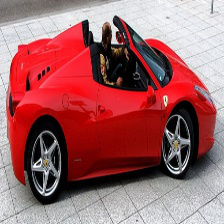

In [27]:
img = open_image(os.path.join('data/test', '%05d.jpg' % (1 + 1)))
img

In [28]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class, pred_idx.item()

(Category 0103, 102)

In [29]:
def write_prediction(num_samples):
    start = time.time()
    out = open('result-152-32e.txt', 'a')
    for i in range(num_samples):
        filename = os.path.join('data/test', '%05d.jpg' % (i + 1))
        img = open_image(filename)
        pred_class,pred_idx,outputs = learn.predict(img)
        class_id = int(repr(pred_class).split(' ')[1])
        out.write('{}\n'.format(str(class_id)))

    end = time.time()
    seconds = end - start
    print('avg fps: {}'.format(str(num_samples / seconds)))

    out.close()

In [33]:
write_prediction(8041)

avg fps: 40.353544157048134
